In [26]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
# Loading  CSV files
customers_file_path = '/content/Customers.csv'
transactions_file_path = '/content/Transactions.csv'

# Reading the CSV files
customers = pd.read_csv(customers_file_path)
transactions = pd.read_csv(transactions_file_path)

In [27]:
# Displaying the first few rows
customers.head(), transactions.head()

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  )

In [28]:
# Merging the customers and transactions datasets
data_df = pd.merge(transactions, customers, on='CustomerID', how='inner')
data_df

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11


In [29]:
# Aggregating transaction data for clustering
customer_agg = data_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Quantity': 'mean'
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionFrequency',
    'Quantity': 'AvgQuantity'
}).reset_index()

In [30]:
# Adding profile information (region) to the aggregated data
df = pd.merge(customer_agg, data_df[['CustomerID', 'Region']], on='CustomerID', how='inner')

# Displaying the processed data ready for clustering
df.head()

,CustomerID,TotalSpending,TransactionFrequency,AvgQuantity,Region
0,C0001,3354.52,5,2.4,South America
1,C0001,3354.52,5,2.4,South America
2,C0001,3354.52,5,2.4,South America
3,C0001,3354.52,5,2.4,South America
4,C0001,3354.52,5,2.4,South America


In [31]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['TotalSpending', 'TransactionFrequency', 'AvgQuantity']),
    ('cat', OneHotEncoder(drop='first'), ['Region'])
])
preprocessor
# Applying preprocessing to the data
x = preprocessor.fit_transform(df)

In [32]:
print(x)

[[-0.40900658 -0.46334798 -0.26773145  0.          0.          1.        ]
 [-0.40900658 -0.46334798 -0.26773145  0.          0.          1.        ]
 [-0.40900658 -0.46334798 -0.26773145  0.          0.          1.        ]
 ...
 [ 0.36002727 -0.46334798  1.29566386  0.          0.          0.        ]
 [ 0.36002727 -0.46334798  1.29566386  0.          0.          0.        ]
 [ 0.36002727 -0.46334798  1.29566386  0.          0.          0.        ]]


In [33]:
# Trying different numbers of clusters and calculating the Davies-Bouldin Index
db_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(x)
    db_index = davies_bouldin_score(x, clusters)
    db_scores.append(db_index)

In [34]:
#(minimum DB Index)
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
optimal_clusters

10

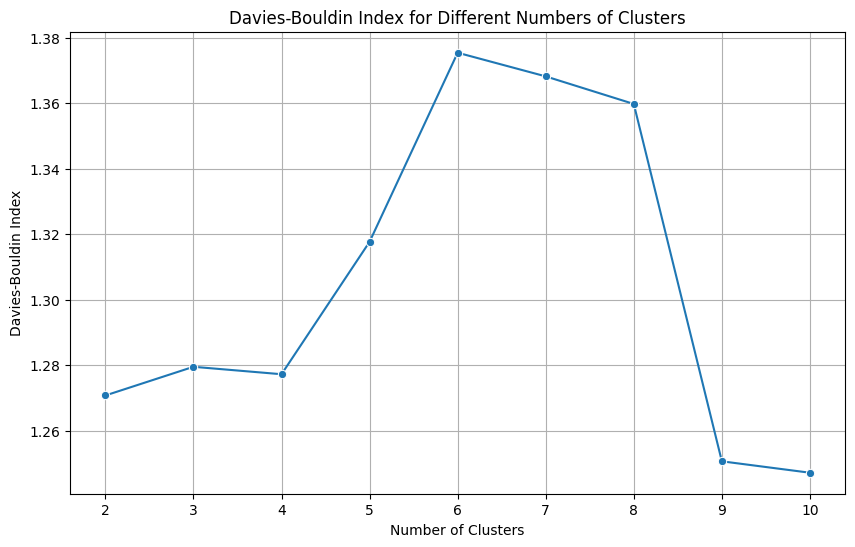

In [35]:
# Plotting the Davies-Bouldin Index for different numbers of clusters
plt.figure(figsize=(10, 6))
sns.lineplot(x=cluster_range, y=db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [36]:
# Optimal number of clusters
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
final_clusters = kmeans_optimal.fit_predict(x)

# Add cluster labels to the original data
df['Cluster'] = final_clusters

# Final report
print("Number of clusters formed:", optimal_clusters)
print("Davies-Bouldin Index (optimal):", min(db_scores))



Number of clusters formed: 10
Davies-Bouldin Index (optimal): 1.247137385195408


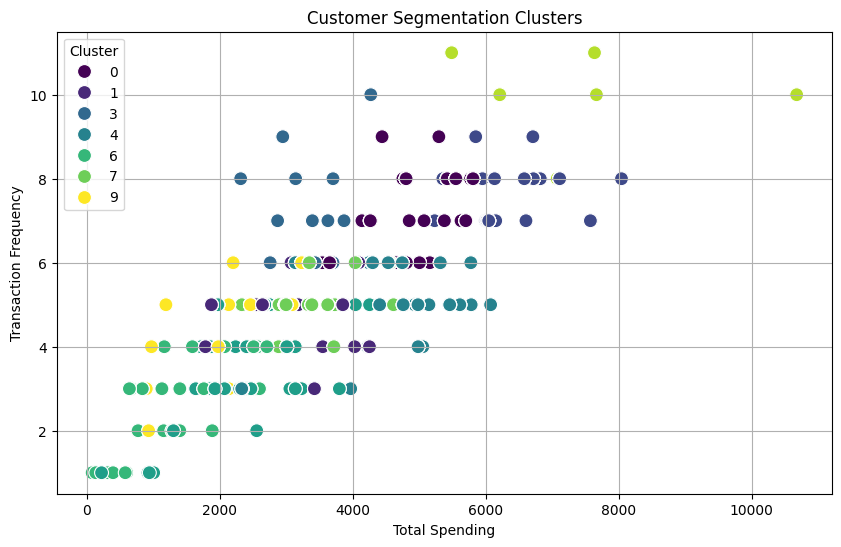

In [37]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df['TotalSpending'],
    y=df['TransactionFrequency'],
    hue=df['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Frequency')
plt.legend(title='Cluster')
plt.grid()
plt.show()